# Modelling Solar generation across Multiple Sites - Part 2

In [Part 1](SolarGenerationTimeSeries_Part1.ipynb), we have explored the SETIS PV generation dataset and built a powerful and performant model using 
`timeserio`'s `MultiModel` and datetime feature generation pipelines. In this part, we instead train an auto-regressive model using more advanced batch generator features.

Remember the metrics our previous model achieved on the train/test split (without any parameter tuning):

|&nbsp;| train | test |
|---|---|---|
| MSE | 0.0063 | 0.0068 |
| MAE | 0.0401 | 0.0424 |

In this notebook, we will build a simple model to create short-range predictions (between 1 and 2 hours ahead) based on recent history (say 6h)

## Load the data from parquet

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%%time
df = pd.read_parquet("~/tmp/datasets/EMHIRESPV_TSh_CF_Country_19862015_tall.parquet")

CPU times: user 1.09 s, sys: 608 ms, total: 1.7 s
Wall time: 449 ms


In [3]:
plot_countries = ['ES', 'UK', 'FI', ]

## Split into train-test sets

In [4]:
df_dev = df.iloc[:100]
df_train, df_test = df[df['Year'] < 1995], df[df['Year'] >= 1995]
len(df_train), len(df_test)

(2761080, 6442800)

## Auto-regressive model

In an auto-regressive model, we treat past values of the timeseries as input features to the forecasting model.
While the functional form of the model is important, deep learning frameworks give us an easy way to try different approaches including CNNs, RNNs, etc.

A key part remains however - we must be able to supply abundant training examples, each consisting of a window of consecutive values, the target, and (optinally) the time between the end of the window and the target (the "forecast horizon"). A long timeseries can be used to generate many examples simply by sampling the windows randomly from the original timeseries - in fact, for a realistic timeseries, pre-generating training examples in memory is prohibitively expensive. `timeserio` provides a way to generate sequence training examples on-demand from data held in memory, or even from datasets partitioned into multiple files.

In [5]:
from timeserio.batches.chunked.pandas import SequenceForecastBatchGenerator

batchgen_train = SequenceForecastBatchGenerator(
    df=df_train, batch_size=2**15,
    sequence_length=6,
    sequence_columns=["generation", "Time_step"],
    last_step_columns=["Time_step"],
    forecast_steps_min=1,
    forecast_steps_max=2,
    batch_offset=True,
    id_column="country",
    batch_aggregator=1
)

Using TensorFlow backend.


In [6]:
len(batchgen_train)

35

In [7]:
%%time
batch = batchgen_train[0]

CPU times: user 116 ms, sys: 4.71 ms, total: 121 ms
Wall time: 119 ms


In [8]:
batch.head(2)

country generation Time_step seq_generation                                \
                                            0         1         2         3   
0      HU   0.070537         9       0.000000  0.000000  0.000000  0.000000   
1      HU   0.084160        16       0.070537  0.078465  0.072669  0.082293   

                      seq_Time_step                     end_of_Time_step  
          4         5             0   1   2   3   4   5                   
0  0.000000  0.030528             3   4   5   6   7   8                8  
1  0.069379  0.062412             9  10  11  12  13  14               14

In [9]:
%%time
batch = batchgen_train[-1]

CPU times: user 158 ms, sys: 3.54 ms, total: 162 ms
Wall time: 161 ms


In [10]:
batch.head(2)

country generation Time_step seq_generation                               \
                                            0         1         2        3   
0      RS   0.066365         9       0.000000  0.000000  0.000000  0.00000   
1      RS   0.000000        16       0.066365  0.088595  0.083035  0.09524   

                      seq_Time_step                     end_of_Time_step  
          4         5             0   1   2   3   4   5                   
0  0.000000  0.035935             3   4   5   6   7   8                8  
1  0.090335  0.071625             9  10  11  12  13  14               14

### Sequence and Forecast horizon features

In [11]:
from timeserio.pipeline import Pipeline
from timeserio.preprocessing import PandasColumnSelector, PandasValueSelector

class ColumnDifferenceValues:
    """Compute difference feature of two columns"""
    def __init__(self, *, col_plus, col_minus):
        self.col_plus = col_plus
        self.col_minus = col_minus
    
    def fit(self, *args, **kwargs):
        return self
    
    def fit_transform(self, df, *args, **kwargs):
        return self.transform(df, *args, **kwargs)

    def transform(self, df, *args, **kwargs):
        return (df[self.col_plus] - df[self.col_minus]).values.reshape(-1, 1)

    
seq_pipeline = PandasValueSelector("seq_generation")
fc_horizon_pipeline = ColumnDifferenceValues(col_plus="Time_step", col_minus="end_of_Time_step")
target_pipeline = PandasValueSelector("generation")

### Define the Neural Network Architecture

We define a regression network with two inputs: sequence of previous readings, and the forecast horizon

In [19]:
from timeserio.keras.multinetwork import MultiNetworkBase

from keras.layers import Input, Dense, Flatten, Concatenate, Reshape, Permute, Conv1D, BatchNormalization, MaxPool1D, Activation
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

class ARForecastingNetwork(MultiNetworkBase):
    def _model(
        self,
        *,
        seq_length=6,  # number of real-valued features
        filters=(1, ),
        kernel_sizes=(1, ),
        strides=(1, ),
        pools=(1, ),
        hidden_units=(8, 8),
        lr=0.01
    ):
        horizon_input = Input(shape=(1,), name='horizon')
        seq_input = Input(shape=(seq_length,), name='sequence')
        encoding = Reshape(
            target_shape=(-1, 1)
        )(seq_input)
                
        for idx, (_filters, _kernel_size, _strides, _pool) in enumerate(zip(filters, kernel_sizes, strides, pools)):
            encoding = Conv1D(filters=_filters, kernel_size=_kernel_size, strides=_strides, padding="same", name=f"conv_{idx}")(encoding)
            encoding = BatchNormalization()(encoding)
            encoding = Activation(activation='relu')(encoding)
            encoding = MaxPool1D(pool_size=_pool)(encoding)
        encoding = Flatten()(encoding)

        output = Concatenate(name='concatenate')([encoding, horizon_input])
        for idx, _hidden_units in enumerate(hidden_units):
            output = Dense(_hidden_units, activation='relu', name=f'dense_{idx}')(output)
        output = Dense(1, name='generation', activation='relu')(output)
        
        encoding_model = Model(seq_input, encoding)
        forecasting_model = Model([seq_input, horizon_input], output)
        
        optimizer = Adam(lr=lr)
        forecasting_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
        
        return {'encoder': encoding_model, 'forecast': forecasting_model}

    
multinetwork = ARForecastingNetwork(seq_length=6, lr=0.001)

In [20]:
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

def vis_model(model, show_shapes=False, show_layer_names=True, rankdir='TB'):
    """Visualize model in a notebook."""
    return SVG(
        model_to_dot(
            model, show_shapes=show_shapes, show_layer_names=show_layer_names, rankdir=rankdir
        ).create(prog='dot', format='svg')
    )

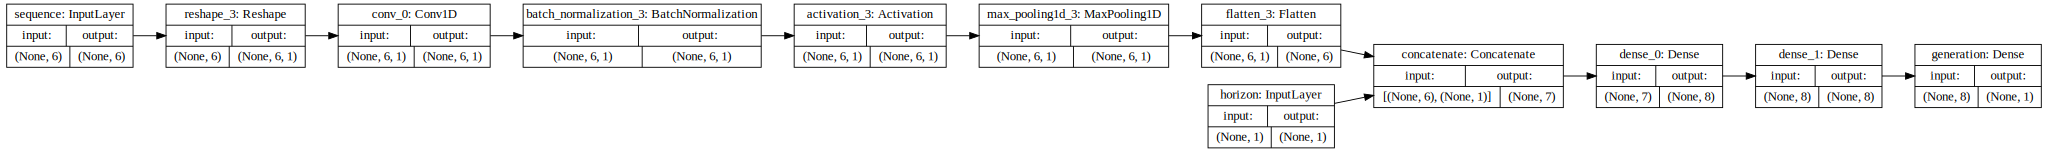

In [21]:
vis_model(multinetwork.model["forecast"], show_shapes=True, rankdir="LR")

### Connect feature pipelines to the neural network

In [22]:
from timeserio.pipeline import MultiPipeline

In [23]:
multipipeline = MultiPipeline({
    "sequence": seq_pipeline,
    "horizon": fc_horizon_pipeline,
    "target": target_pipeline
})

In [24]:
from timeserio.multimodel import MultiModel

manifold = {
    # keras_model_name: (input_pipes, output_pipes)
    "encoder": ("sequence", None),
    "forecast": (["sequence", "horizon"], "target")
}

multimodel = MultiModel(
    multinetwork=multinetwork,
    multipipeline=multipipeline,
    manifold=manifold
)

### Fit model from the batch generator

`multimodel.fit_generator()` will apply pipelines correctly to the training batch generator, and, if `validation_data` is provided in the form of another (pandas) batch generator,
evaluate the relevant metrics. In addition, feature extraction for each batch will benefit from the `workers` parallelism.

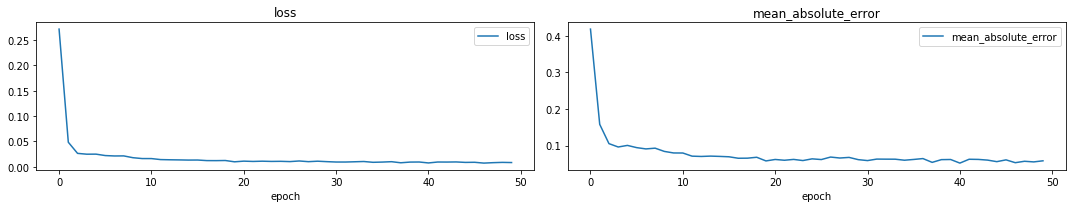

In [25]:
from kerashistoryplot.callbacks import PlotHistory
plot_callback = PlotHistory(figsize=(15, 3), n_cols=3, batches=False)

multimodel.fit_generator(
    batchgen_train, model="forecast", verbose=1, epochs=50,
    reset_weights=True,
    workers=4,
    callbacks=[plot_callback]
)

persist the model:

In [27]:
from timeserio.utils.pickle import loadf, dumpf
dumpf(multimodel, "/tmp/PV_model_2.pickle")

### Evaluate performance on test data
We can evaluate the model on the validation data generator, which can also be out-of-memory:

In [28]:
batchgen_test = SequenceForecastBatchGenerator(
    df=df_test, batch_size=2**15,
    sequence_length=6,
    sequence_columns=["generation", "Time_step"],
    last_step_columns=["Time_step"],
    forecast_steps_min=1,
    forecast_steps_max=2,
    batch_offset=False,
    id_column="country",
    batch_aggregator=1
)

In [29]:
multimodel.evaluate_generator(batchgen_test, model="forecast", verbose=1)

35/35 [==============================] - 9s 254ms/step


[0.008467954644999866, 0.051904945554477826]

While the model takes longer to train (and longer still with practical encoder architectures), it can be tuned to achieve higher performanec, especially if encodings are combined with datetime features.